# Communication with Self-Interference-Cancelling Beam Codebook

This notebook is heavily based on Sionna's tutorial
[MIMO OFDM Transmissions over the CDL Channel Model](https://nvlabs.github.io/sionna/examples/MIMO_OFDM_Transmissions_over_CDL.html),
more specifically on its
[Downlink Simulation in the Frequency Domain](https://nvlabs.github.io/sionna/examples/MIMO_OFDM_Transmissions_over_CDL.html#Downlink-Transmission-in-the-Frequency-Domain)
Here is Sionna's schematic diagram of the system model with all required components:

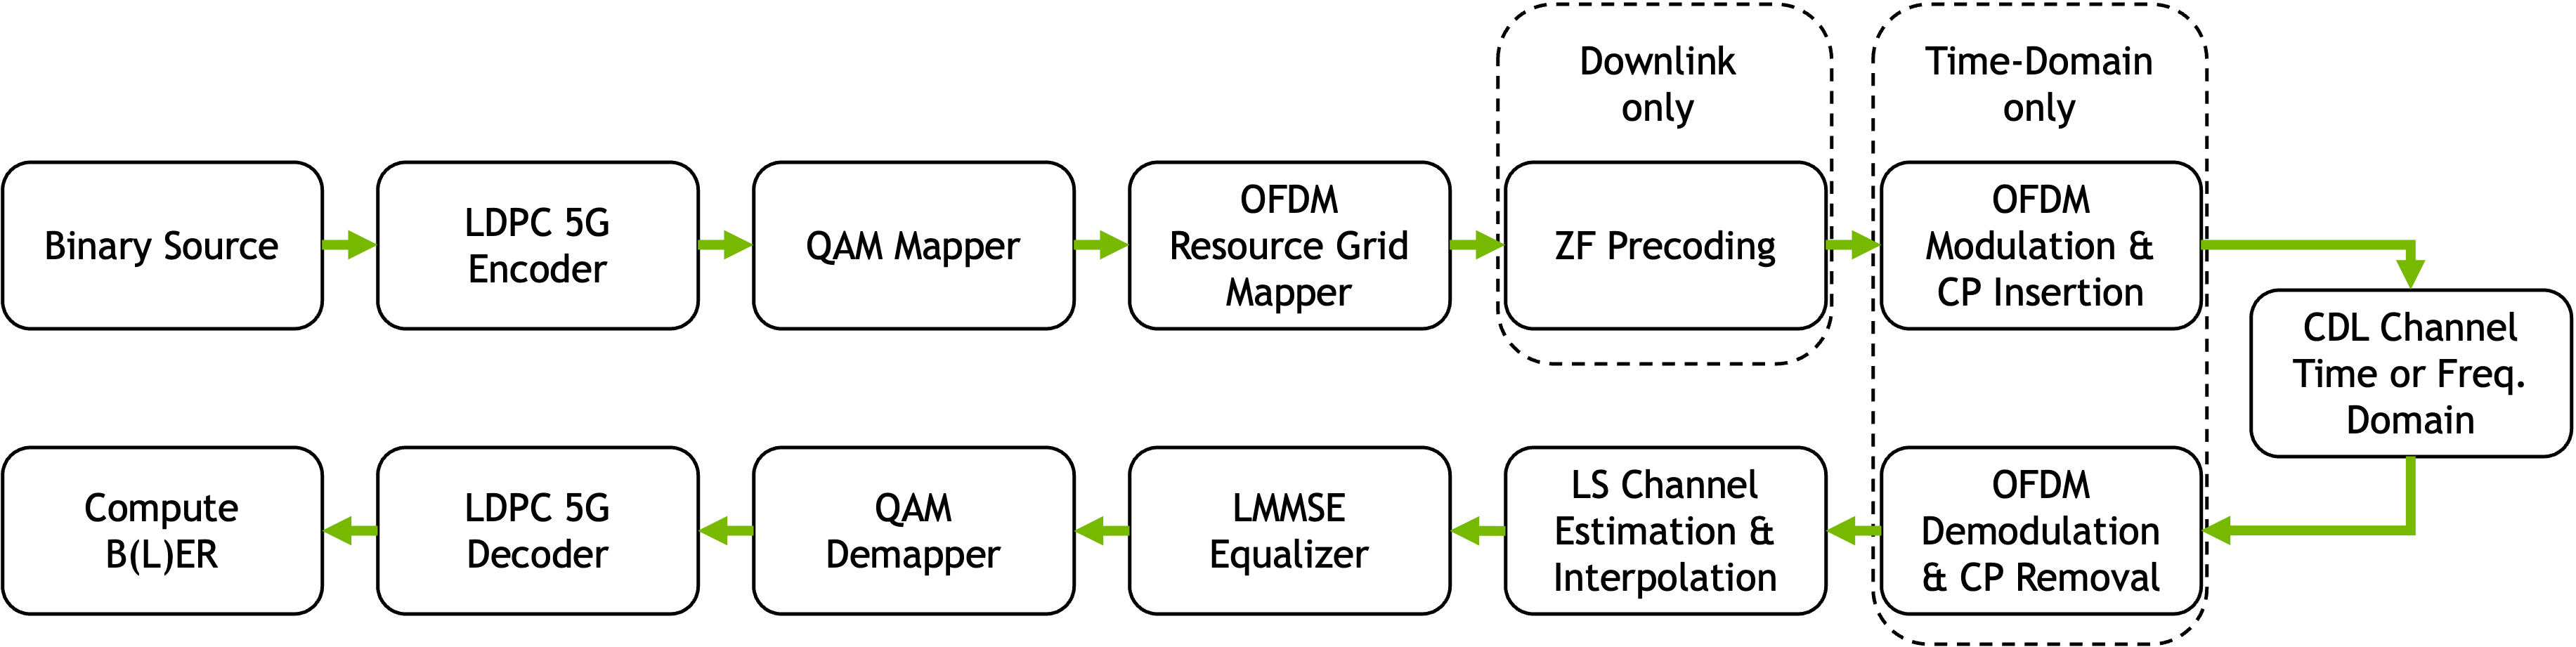

The setup includes (removed original components are ~struck through~, added components in _italics_):

* 5G LDPC FEC
* QAM modulation
* OFDM resource grid with configurabel pilot pattern
* Multiple data streams
* 3GPP 38.901 CDL channel models and antenna patterns
* _Beamspace channel conversion_
* ZF Precoding ~with perfect channel state information~
* LS Channel estimation with ~nearest-neighbor~ _linear_ interpolation ~as well as perfect CSI~
* LMMSE MIMO equalization



### GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
import tensorflow_probability as tfp
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import json

import numpy as np
import time

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.channel import ApplyOFDMChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.nr import CarrierConfig

from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.utils.metrics import compute_ber

from pathlib import Path

from cissir import params
from cissir.physics import delay2distance
from cissir.beamforming import plot_beamforming_polar, sionna_mimo_axes, Beamspace

base_path = Path.cwd().parent
plot_path = base_path/"plots"
res_path = base_path/"results"

## System Setup <a class="anchor" id="System-Setup"></a>

We will now configure all components of the system model step-by-step.

### Stream Management <a class="anchor" id="Stream-Management"></a>

For any type of MIMO simulations, it is useful to setup a [StreamManagement](https://nvlabs.github.io/sionna/api/mimo.html#stream-management) object.
It determines which transmitters and receivers communicate data streams with each other.
In our scenario, we will configure a single UT and BS with multiple antennas each.
Whether the UT or BS is considered as a transmitter depends on the `direction`, which can be
either uplink or downlink. The [StreamManagement](https://nvlabs.github.io/sionna/api/mimo.html#stream-management) has many properties that are used by other components,
such as precoding and equalization.

We will configure the system here such that the number of streams per transmitter (in both uplink and donwlink)
is equal to the number of UT antennas.

In [3]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m

ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx

# Number of beams in the codebook
L_r = params.num_beams
L_t = params.num_beams

# Number of usable beams == RF tx chains
L_rf = 4

beam_perc = round((1-L_rf/L_t)*100)

ant_pattern = "38.901"
ant_pol = params.antenna_polarization

Q_bits = 6 # Each complex component (I and Q) is quantized with Q bits

In [5]:
# Define the number of UT and BS antennas.
# For the CDL model, that will be used in this notebook, only
# a single UT and BS are supported.
num_ut = 1
num_bs = 1
num_ut_ant = 2
num_bs_ant = N_t

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
num_streams_per_tx = num_ut_ant

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

In [6]:
## Waveform params

c_config = CarrierConfig(subcarrier_spacing=params.subcarrier_spacing_khz,
                         cyclic_prefix="normal")
# Reduce bandwidth below 30 MHz to run simulations 
num_subcarriers = params.num_prb//4 * params.subcarriers_per_rb
subcarrier_spacing = params.subcarrier_spacing_khz * 1e3

fft_size = 2 ** int(np.ceil(np.log2(num_subcarriers)))
Ts_sec = 1/(fft_size * subcarrier_spacing)


cyclic_prefix_length = round(c_config.cyclic_prefix_length/Ts_sec)
digital_bw_hz = 1/Ts_sec

sig_bw_hz = num_subcarriers * subcarrier_spacing
sig_bw_frac = num_subcarriers/fft_size

t_channel_s = tf.range(cyclic_prefix_length, dtype=tf.float64) * Ts_sec
distance_m = delay2distance(t_channel_s)

## OFDM configuration
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
pilot_pattern = None # Pilot pattern
pilot_ofdm_symbol_indices = None # Index of OFDM symbols carrying pilots

null_carriers = fft_size - num_subcarriers
num_guard_carriers = [null_carriers//2, null_carriers//2-1] # Number of guard carriers on each side

### OFDM Resource Grid & Pilot Pattern <a class="anchor" id="OFDM-Resource-Grid-&-Pilot-Pattern"></a>

Next, we configure an OFDM [ResourceGrid](https://nvlabs.github.io/sionna/api/ofdm.html#resource-grid) spanning multiple OFDM symbols.
The resource grid contains data symbols and pilots and is equivalent to a
*slot* in 4G/5G terminology. Although it is not relevant for our simulation, we null the DC subcarrier
and a few guard carriers to the left and right of the spectrum. Also a cyclic prefix is added.

During the creation of the [ResourceGrid](https://nvlabs.github.io/sionna/api/ofdm.html#resource-grid), a [PilotPattern](https://nvlabs.github.io/sionna/api/ofdm.html#pilot-pattern) is automatically generated.
We could have alternatively created a [PilotPattern](https://nvlabs.github.io/sionna/api/ofdm.html#pilot-pattern) first and then provided it as initialization parameter.

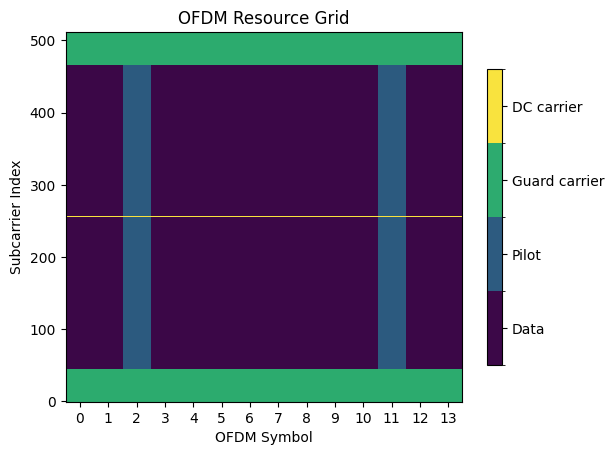

In [7]:
rg = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                  fft_size=fft_size,
                  subcarrier_spacing=subcarrier_spacing,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=cyclic_prefix_length,
                  num_guard_carriers=num_guard_carriers,
                  dc_null=dc_null,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])
rg.show();

As can be seen in the figure above, the resource grid spans 76 subcarriers over 14 OFDM symbols. A DC guard carrier as well as some guard carriers to the left and right of the spectrum are nulled. The third and twelfth OFDM symbol are dedicated to pilot transmissions. 

Let us now have a look at the pilot pattern used by the transmitter. 

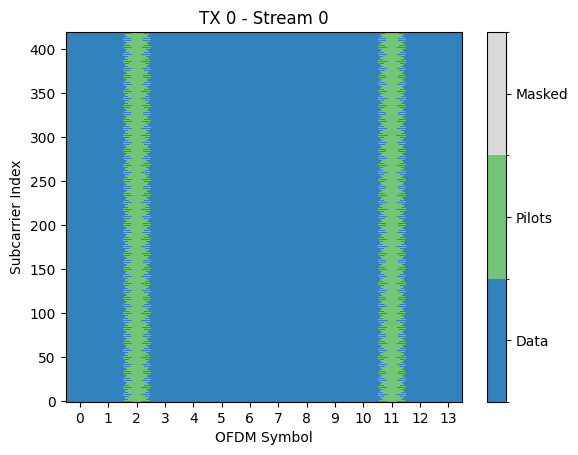

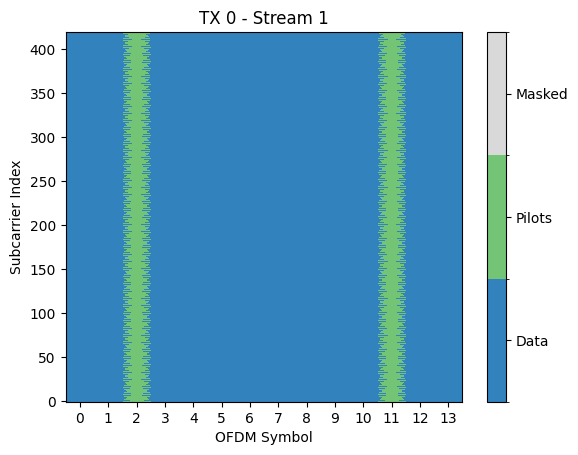

In [8]:
rg.pilot_pattern.show();

The pilot patterns are defined over the resource grid of *effective subcarriers* from which the nulled DC and guard carriers have been removed. This leaves us in our case with 76 - 1 (DC) - 5 (left guards) - 6 (right guards) = 64 effective subcarriers.

While the resource grid only knows which resource elements are reserved for pilots, it is the pilot pattern that defines what is actually transmitted on them. In our scenario, we have four transmit streams and configured the [KroneckerPilotPattern](https://nvlabs.github.io/sionna/api/ofdm.html#kroneckerpilotpattern). All streams use orthogonal pilot sequences, i.e., one pilot on every fourth subcarrier. You have full freedom to configure your own [PilotPattern](https://nvlabs.github.io/sionna/api/ofdm.html#pilotpattern).

Let us now have a look at the actual pilot sequences for all streams which consists of random QPSK symbols.
By default, the pilot sequences are normalized, such that the average power per pilot symbol is
equal to one. As only every fourth pilot symbol in the sequence is used, their amplitude is scaled by a factor of two.

Average energy per pilot symbol: 1.00


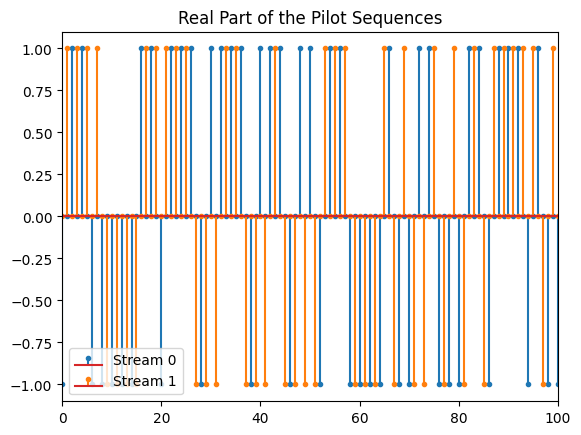

In [9]:
plt.figure()
plt.title("Real Part of the Pilot Sequences")
for i in range(num_streams_per_tx):
    plt.stem(np.real(rg.pilot_pattern.pilots[0, i]),
             markerfmt="C{}.".format(i), linefmt="C{}-".format(i),
             label="Stream {}".format(i))
plt.xlim(0, 100)
plt.legend()
print("Average energy per pilot symbol: {:1.2f}".format(np.mean(np.abs(rg.pilot_pattern.pilots[0,0])**2)))

### Antenna Arrays <a class="anchor" id="Antenna-Arrays"></a>

Next, we need to configure the antenna arrays used by the UT and BS.
This can be ignored for simple channel models, such as [AWGN](https://nvlabs.github.io/sionna/api/channel.html#awgn), [flat-fading](https://nvlabs.github.io/sionna/api/channel.html#flat-fading-channel), [RayleighBlockFading](https://nvlabs.github.io/sionna/api/channel.html#rayleigh-block-fading), or [TDL](https://nvlabs.github.io/sionna/api/channel.html#tapped-delay-line-tdl) which do not account for antenna array geometries and antenna radiation patterns. However, other models, such as [CDL](https://nvlabs.github.io/sionna/api/channel.html#clustered-delay-line-cdl), [UMi](https://nvlabs.github.io/sionna/api/channel.html#urban-microcell-umi), [UMa](https://nvlabs.github.io/sionna/api/channel.html#urban-macrocell-uma), and [RMa](https://nvlabs.github.io/sionna/api/channel.html#rural-macrocell-rma) from the 3GPP 38.901 specification, require it.

We will assume here that UT and BS antenna arrays are composed of dual cross-polarized antenna elements with an antenna pattern defined in the 3GPP 38.901 specification. By default, the antenna elements are spaced half of a wavelength apart in both vertical and horizontal directions. You can define your own antenna geometries an radiation patterns if needed.

An [AntennaArray](https://nvlabs.github.io/sionna/api/channel.html#antennaarray) is always defined in the y-z plane. It's final orientation will be determined by the orientation of the UT or BS. This parameter can be configured in the [ChannelModel](https://nvlabs.github.io/sionna/api/channel.html#channel-model-interface) that we will create later.

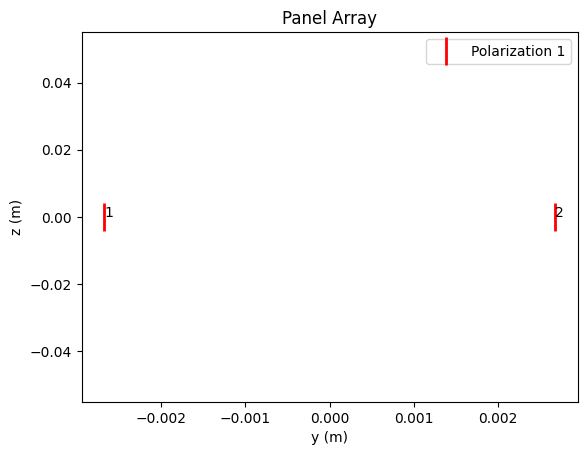

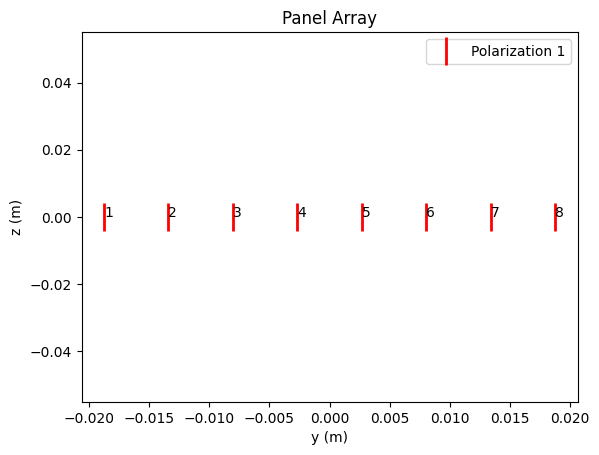

In [10]:
carrier_frequency = fc # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

ut_array = AntennaArray(num_rows=1,
                        num_cols=int(num_ut_ant),
                        polarization="single",
                        polarization_type=ant_pol,
                        antenna_pattern=ant_pattern,
                        carrier_frequency=carrier_frequency)
ut_array.show()

bs_array = AntennaArray(num_rows=1,
                        num_cols=int(num_bs_ant),
                        polarization="single",
                        polarization_type=ant_pol,
                        antenna_pattern=ant_pattern,
                        carrier_frequency=carrier_frequency)
bs_array.show()

### CDL Channel Model <a class="anchor" id="CDL-Channel-Model"></a>

Now, we will create an instance of the CDL channel model.

In [11]:
delay_spread = 300e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value. 

direction = "downlink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.
cdl_model = "C"       # Suitable values are ["A", "B", "C", "D", "E"]

# Assume static user
speed = 0
#speed = 10            # UT speed [m/s]. BSs are always assumed to be fixed.
                      # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
# cdl() will generate CIRs that can be converted to discrete time or discrete frequency.
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)

#### CIR Sampling Process <a class="anchor" id="CIR-Sampling-Process"></a>

The instance `cdl` of the [CDL](https://nvlabs.github.io/sionna/api/channel.html#clustered-delay-line-cdl) [ChannelModel](https://nvlabs.github.io/sionna/api/channel.html#channel-model-interface) can be used to generate batches of random realizations of continuous-time
channel impulse responses, consisting of complex gains `a` and delays `tau` for each path. 
To account for time-varying channels, a channel impulse responses is sampled at the `sampling_frequency` for `num_time_samples` samples.
For more details on this, please have a look at the [API documentation](https://nvlabs.github.io/sionna/api/channel.html) of the channel models.

In order to model the channel in the frequency domain, we need `num_ofdm_symbols` samples that are taken once per `ofdm_symbol_duration`, which corresponds to the length of an OFDM symbol plus the cyclic prefix.

In [12]:
a, tau = cdl(batch_size=32, num_time_steps=rg.num_ofdm_symbols, sampling_frequency=1/rg.ofdm_symbol_duration)

The path gains `a` have shape\
`[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]`\
and the delays `tau` have shape\
`[batch_size, num_rx, num_tx, num_paths]`.

In [13]:
print("Shape of the path gains: ", a.shape)
print("Shape of the delays:", tau.shape)

Shape of the path gains:  (32, 1, 2, 1, 8, 24, 14)
Shape of the delays: (32, 1, 1, 24)


The delays are assumed to be static within the time-window of interest. Only the complex path gains change over time.
The following two figures depict the channel impulse response at a particular time instant and the time-evolution of the gain of one path, respectively.

Text(0, 0.5, '$|a|$')

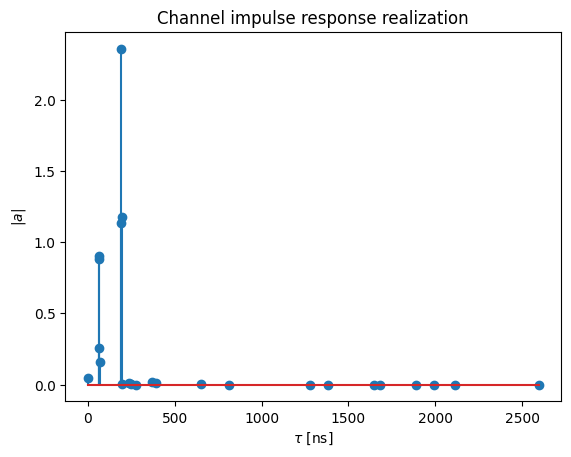

In [14]:
plt.figure()
plt.title("Channel impulse response realization")
plt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")


#### Generate the Channel Frequency Response <a class="anchor" id="Generate-the-Channel-Frequency-Response"></a>

If we want to use the continuous-time channel impulse response to simulate OFDM transmissions
under ideal conditions, i.e., no inter-symbol interference, inter-carrier interference, etc.,
we need to convert it to the frequency domain. 

This can be done with the function [cir_to_ofdm_channel](https://nvlabs.github.io/sionna/api/channel.html#cir-to-ofdm-channel) that computes the Fourier transform of the
continuous-time channel impulse response at a set of `frequencies`, corresponding to the
different subcarriers. The frequencies can be obtained with the help of the convenience function
[subcarrier_frequencies](https://nvlabs.github.io/sionna/api/channel.html#subcarrier-frequencies).

In [15]:
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)

Let us have a look at the channel frequency response at a given time instant:

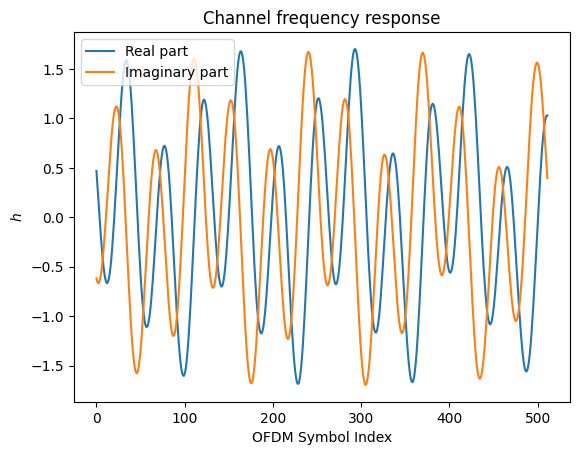

In [16]:
plt.figure()
plt.title("Channel frequency response")
plt.plot(np.real(h_freq[0,0,0,0,0,0,:]))
plt.plot(np.imag(h_freq[0,0,0,0,0,0,:]))
plt.xlabel("OFDM Symbol Index")
plt.ylabel(r"$h$")
plt.legend(["Real part", "Imaginary part"]);

We can apply the channel frequency response to a given input with the [ApplyOFDMChannel](https://nvlabs.github.io/sionna/api/channel.html#applyofdmchannel) layer. This layer can also add additive white Gaussian noise (AWGN) to the channel output.

In [17]:
# Function that will apply the channel frequency response to an input signal
channel_freq = ApplyOFDMChannel(add_awgn=True)

### Beam Codebook

In [18]:
with np.load(res_path/"sdp_ph_full_codebooks.npz") as cb_data:
    att_array =  cb_data["att_opt"]
    att_worse_i = len(att_array)-1
    att_medium_i = len(att_array)//2
    att_hi_i = (3 * len(att_array))//4
    att_index = att_worse_i
    att_worse = att_array[att_worse_i]
    att_medium = att_array[att_medium_i]
    att_hi = att_array[att_hi_i]
    opt_att = att_array[att_index]
    print(f"Loading codebooks for {opt_att} dB SI attenuation")
    opt_tx_codebook = cb_data["tx"][att_index,]
    worse_tx_codebook = cb_data["tx"][att_worse_i,]
    med_tx_codebook = cb_data["tx"][att_medium_i,]
    hi_tx_codebook = cb_data["tx"][att_hi_i,]
    dft_tx_codebook = cb_data["tx"][0,]
    assert opt_tx_codebook.shape == (N_t, L_t), "Unexpected shape for Tx codebook"
    assert dft_tx_codebook.shape == (N_t, L_t), "Unexpected shape for Tx codebook"

    tx_degs = cb_data["tx_degrees"]


Loading codebooks for 107.9431345057482 dB SI attenuation


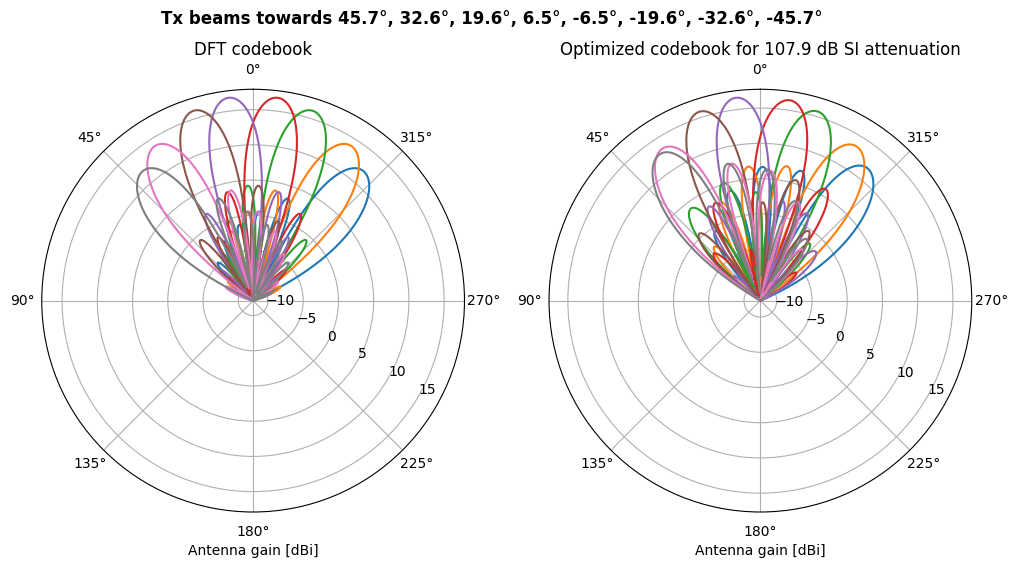

In [19]:
antenna_pattern = bs_array.ant_pol1.field
rad_pattern = lambda d: sum(np.abs(p)**2 for p in antenna_pattern(np.pi/2, tf.cast(d, dtype=tf.float32)))

f, (ax_dft, ax_opt) = plt.subplots(1, 2, figsize=(12,6), subplot_kw={'projection': 'polar'}) 
_ = plot_beamforming_polar(dft_tx_codebook, transmit=True, element_pattern=rad_pattern, axis=ax_dft)
_ = plot_beamforming_polar(opt_tx_codebook, transmit=True, element_pattern=rad_pattern, axis=ax_opt)

_ = ax_dft.set_title("DFT codebook")
_ = ax_opt.set_title(f"Optimized codebook for {opt_att:.1f} dB SI attenuation")
plt.suptitle(f"Tx beams towards "+", ".join(f"{bd:.1f}°" for bd in tx_degs[::-1]), weight="bold")

beam_degs = tx_degs

In [20]:
dft_cb_matrix = tf.cast(dft_tx_codebook, dtype=tf.complex64)  # (N_t, L_t)
opt_cb_matrix = tf.cast(opt_tx_codebook, dtype=tf.complex64)
worse_cb_matrix = tf.cast(worse_tx_codebook, dtype=tf.complex64)
medium_cb_matrix = tf.cast(med_tx_codebook, dtype=tf.complex64)
hi_cb_matrix = tf.cast(hi_tx_codebook, dtype=tf.complex64)


rx_axis, tx_axis = sionna_mimo_axes("ofdm")
tx_beamform = Beamspace(transmit_axis=tx_axis)

### Other Physical Layer Components <a class="anchor" id="Other-Physical-Layer-Components"></a>

Finally, we create instances of all other physical layer components we need. Most of these layers are self-explanatory.
For more information, please have a look at the API documentation.

In [21]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.7 # Code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
#modulator = OFDMModulator(rg.cyclic_prefix_length)
#demodulator = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

## Simulations <a class="anchor" id="Simulations"></a>

### Downlink Transmission in the Frequency Domain <a class="anchor" id="Downlink-Transmission-in-the-Frequency-Domain"></a>

We will now simulate a simple downlink transmission in the frequency domain.
In contrast to the uplink, the transmitter is now assumed to precode independent data
streams to each antenna of the receiver based on perfect CSI.

The receiver can either estimate the channel or get access to the effective channel
after precoding.

The first thing to do, is to change the `direction` within the CDL model. This makes the BS the transmitter and the UT the receiver.

In [22]:
direction = "downlink"
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)

The following code shows the other necessary modifications:

In [23]:
batch_size = 100 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory

ebno_db = 30
perfect_csi = False # Change to switch between perfect and imperfect CSI
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)

b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg_ = rg_mapper(x)
cir = cdl(batch_size, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)

h_dft = tx_beamform([h_freq, dft_cb_matrix])
h_sens = tx_beamform([h_freq, opt_cb_matrix])

h_power = tf.math.reduce_variance(h_dft, axis=(2, 5, 6), keepdims=True)
h_threshold = tfp.stats.percentile(h_power, 25, axis=-3, keepdims=True)
h_beam_sel = tf.cast(tf.greater_equal(h_power, h_threshold), dtype=h_dft.dtype)

# Precode the transmit signal in the frequency domain
# It is here assumed that the transmitter has perfect knowledge of the channel
# One could here reduce this to perfect knowledge of the channel for the first
# OFDM symbol, or a noisy version of it to take outdated transmit CSI into account.
# `g` is the post-beamforming or `effective channel` that can be
# used to simulate perfect CSI at the receiver.
x_rg, g = zf_precoder([x_rg_, h_dft * h_beam_sel])

y = channel_freq([x_rg, h_sens * h_beam_sel, no])

h_hat, err_var = ls_est([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))

BER: 0.0


We do not explain here on purpose how to model the downlink transmission in the time domain
as it is a good exercise for the reader to do it her/himself. The key steps are:

* Sample the channel impulse response at the Nyquist rate.
* Downsample it to the OFDM symbol (+ cyclic prefix) rate (look at the uplink example).
* Convert the downsampled CIR to the frequency domain.
* Give this CSI to the transmitter for precoding.
* Convert the CIR to discrete-time to compute the channel output in the time domain.

### Understand the Difference Between the CDL Models <a class="anchor" id="Understand-the-Difference-Between-the-CDL-Models"></a>

Before we proceed with more advanced simulations, it is important to understand the differences
between the different CDL models. The models "A", "B", and "C" are non-line-of-sight (NLOS) models,
while "D" and "E" are LOS. In the following code snippet, we compute the empirical cummulative
distribution function (CDF) of the condition number of the channel frequency response matrix
between all receiver and transmit antennas.

From the figure above, you can observe that the CDL-B and CDL-C models
are substantially better conditioned than the other models. This makes 
them more suitable for MIMO transmissions as we will observe in the next
section.

### Create an End-to-End Keras Model <a class="anchor" id="Create-an-End-to-End-Keras-Model"></a>

For longer simulations, it is often convenient to pack all code into a single
Keras model that outputs batches of transmitted and received information bits
at a given Eb/No point. The following code defines a very general model that can
simulate uplink and downlink transmissions with time or frequency domain modeling
over the different CDL models. It allows to configure perfect or imperfect CSI,
UT speed, cyclic prefix length, and the number of OFDM symbols for pilot transmissions.

In [26]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True. 
sionna.config.xla_compat=True
class Model(tf.keras.Model):
    """This Keras model simulates OFDM MIMO transmissions over the CDL model.
    
    Simulates point-to-point transmissions between a UT and a BS.
    Uplink and downlink transmissions can be realized with either perfect CSI
    or channel estimation. ZF Precoding for downlink transmissions is assumed.
    The receiver (in both uplink and downlink) applies LS channel estimation
    and LMMSE MIMO equalization. A 5G LDPC code as well as QAM modulation are
    used.
    
    Parameters
    ----------
    domain : One of ["time", "freq"], str
        Determines if the channel is modeled in the time or frequency domain.
        Time-domain simulations are generally slower and consume more memory.
        They allow modeling of inter-symbol interference and channel changes
        during the duration of an OFDM symbol.
        
    direction : One of ["uplink", "downlink"], str
        For "uplink", the UT transmits. For "downlink" the BS transmits.
        
    cdl_model : One of ["A", "B", "C", "D", "E"], str
        The CDL model to use. Note that "D" and "E" are LOS models that are
        not well suited for the transmissions of multiple streams.
        
    delay_spread : float
        The nominal delay spread [s].
      
    speed : float
        The UT speed [m/s].
        
    pilot_ofdm_symbol_indices : list, int
        List of integers defining the OFDM symbol indices that are reserved
        for pilots.
      
    Input
    -----
    batch_size : int
        The batch size, i.e., the number of independent Mote Carlo simulations
        to be performed at once. The larger this number, the larger the memory
        requiremens.
        
    ebno_db : float
        The Eb/No [dB]. This value is converted to an equivalent noise power
        by taking the modulation order, coderate, pilot and OFDM-related
        overheads into account.
        
    Output
    ------
    b : [batch_size, 1, num_streams, k], tf.float32
        The tensor of transmitted information bits for each stream.
        
    b_hat : [batch_size, 1, num_streams, k], tf.float32
        The tensor of received information bits for each stream.   
    """
    
    def __init__(self,
                 cdl_model,
                 delay_spread,
                 pilot_ofdm_symbol_indices,
                 precoder_beam_codebook,
                 channel_beam_codebook,
                 domain="freq",
                 direction="downlink",
                 speed=0,
                ):
        super().__init__()
        
        # Provided parameters
        self._domain = domain
        self._direction = direction
        self._cdl_model = cdl_model
        self._delay_spread = delay_spread
        self._speed = speed
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._precoder_beam_codebook = precoder_beam_codebook
        self._channel_beam_codebook = channel_beam_codebook
        self._perfect_csi = False
        
        # System parameters
        self._carrier_frequency = params.fc_hz
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = fft_size
        self._num_ofdm_symbols = 14
        self._num_ut_ant = 2 #num_ut_ant 
        self._num_bs_ant = N_t
        self._num_streams_per_tx = self._num_ut_ant
        self._dc_null = True
        self._num_guard_carriers = num_guard_carriers
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 2 
        self._coderate = 0.7
          
        # Required system components
        self._sm = StreamManagement(np.array([[1]]), self._num_streams_per_tx)
        
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=1,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices) 
        
        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        self._k = int(self._n * self._coderate) 
        
        self._ut_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_ut_ant),
                                      polarization="single",
                                      polarization_type=ant_pol,
                                      antenna_pattern=ant_pattern,
                                      carrier_frequency=self._carrier_frequency)
        
        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant),
                                      polarization="single",
                                      polarization_type=ant_pol,
                                      antenna_pattern=ant_pattern,
                                      carrier_frequency=self._carrier_frequency)
        
        self._cdl = CDL(model=self._cdl_model,
                        delay_spread=self._delay_spread,
                        carrier_frequency=self._carrier_frequency,
                        ut_array=self._ut_array,
                        bs_array=self._bs_array,
                        direction=self._direction,
                        min_speed=self._speed)
        
        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)
        
        if self._domain == "freq":  
            self._channel_freq = ApplyOFDMChannel(add_awgn=True)
        else:
            raise ValueError("Only frequency domain allowed")
               
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)
        
        self._beamforming = Beamspace(transmit_axis=tx_axis)
        
        if self._direction == "downlink":
            self._zf_precoder = ZFPrecoder(self._rg, self._sm, return_effective_channel=True)
        else:
            raise ValueError("Only downlink allowed")
       
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="lin")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)

    @tf.function(jit_compile=True) # See the following guide: https://www.tensorflow.org/guide/function
    def call(self, batch_size, ebno_db):
        
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        b = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
                  
        if self._domain == "freq":
            # Frequency-domain simulations
            
            cir = self._cdl(batch_size, self._rg.num_ofdm_symbols, 1/self._rg.ofdm_symbol_duration)
            h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)
            h_precoder = self._beamforming([h_freq, self._precoder_beam_codebook])
            h_channel = self._beamforming([h_freq, self._channel_beam_codebook])

            h_power = tf.math.reduce_variance(h_precoder, axis=(2, 5, 6), keepdims=True)
            h_threshold = tfp.stats.percentile(h_power, beam_perc, axis=-3, keepdims=True)
            h_beam_sel = tf.cast(tf.greater_equal(h_power, h_threshold), dtype=h_precoder.dtype)

            h_precoder *= h_beam_sel
            h_channel *= h_beam_sel
            
            if self._direction == "downlink":
                x_rg, g = self._zf_precoder([x_rg, h_precoder])
            else:
                raise ValueError("Only downlink allowed")
            
            y = self._channel_freq([x_rg, h_channel, no])
        else:
            raise ValueError("Only frequency domain allowed")
        
        if self._perfect_csi:
            raise ValueError("Only imperfect CSI allowed")          
        else:
            h_hat, err_var = self._ls_est ([y, no])
        
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        llr = self._demapper([x_hat, no_eff])
        b_hat = self._decoder(llr)
            
        return b, b_hat

XLA can lead to reduced numerical precision. Use with care.


### Compare Downlink Performance Over the Different CDL Models <a class="anchor" id="Compare-Downlink-Performance-Over-the-Different-CDL-Models"></a>

We will now compare the downlink performance over the various CDL models assuming perfect CSI at the receiver. 

If you do not want to run the simulation your self, you skip the next cell and visualize the result in the next cell.

In [27]:
codebooks = {"dft": dft_cb_matrix,
             "medium": medium_cb_matrix,
             "high": hi_cb_matrix,
             "worse": worse_cb_matrix}

DL_SIMS = {
    "ebno_db" : list(np.arange(-5, 30, 4.0)),
    "cdl_model" : "C",
    "delay_spread" : 300e-9,
    "domain" : "freq",
    "direction" : "downlink",
    "perfect_csi" : False,
    "speed" : 0.0,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "bler" : [],
    "duration" : None,
    "precoder_codebook": "dft",
    "channel_codebook": ["dft", "medium", "high", "worse"]
}

start = time.time()

for ch_codebook in DL_SIMS["channel_codebook"]:
    
    model = Model(domain=DL_SIMS["domain"],
                  direction=DL_SIMS["direction"],
                  cdl_model=cdl_model,
                  delay_spread=DL_SIMS["delay_spread"],
                  speed=DL_SIMS["speed"],
                  pilot_ofdm_symbol_indices=DL_SIMS["pilot_ofdm_symbol_indices"],
                  precoder_beam_codebook=codebooks[DL_SIMS["precoder_codebook"]],
                  channel_beam_codebook=codebooks[ch_codebook])
    
    ber, bler = sim_ber(model,
                        DL_SIMS["ebno_db"],
                        batch_size=256,
                        max_mc_iter=100,
                        num_target_block_errors=1000)
    
    DL_SIMS["ber"].append(list(ber.numpy()))
    DL_SIMS["bler"].append(list(bler.numpy()))
    
DL_SIMS["duration"] = time.time() -  start

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.1792e-01 | 9.0690e-01 |     2361769 |    10838016 |         1393 |        1536 |        21.0 |reached target block errors
     -1.0 | 1.0553e-01 | 5.5713e-01 |     1524947 |    14450688 |         1141 |        2048 |         0.8 |reached target block errors
      3.0 | 3.6189e-02 | 2.3069e-01 |     1176653 |    32514048 |         1063 |        4608 |         1.8 |reached target block errors
      7.0 | 1.0205e-02 | 7.5087e-02 |      995391 |    97542144 |         1038 |       13824 |         5.5 |reached target block errors
     11.0 | 1.7007e-03 | 1.4766e-02 |      614422 |   361267200 |          756 |       51200 |        20.3 |reached max iter       
     15.0 | 1.9368e-04 | 1.8164e-03 |       69969 |   361267200 |    

In [28]:
with open(res_path/"bler.json", 'w', encoding ='utf8') as json_file:
    json.dump(DL_SIMS, json_file)